<a href="https://www.mbd.rwth-aachen.de/">
    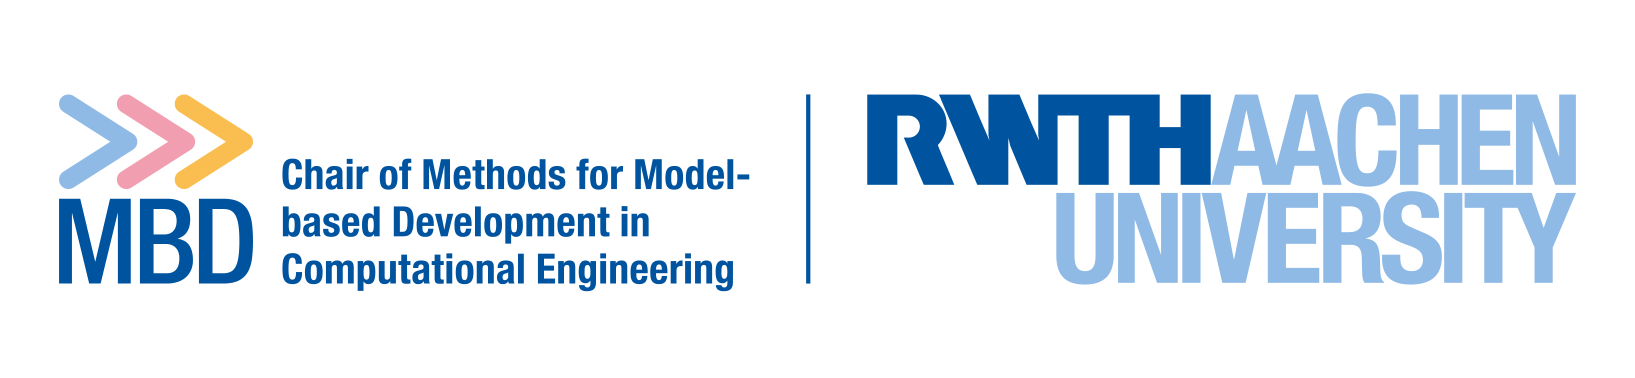
</a>
<a href="https://www.cpbl.rwth-aachen.de/">
    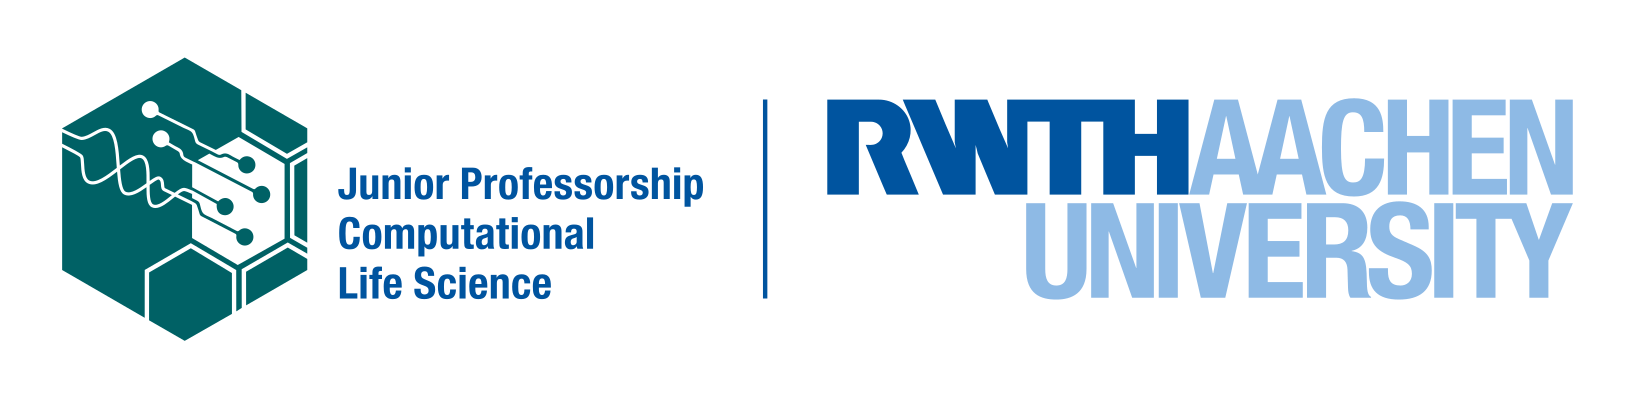
</a>

# Societal Challenges Datathon

Name: **Mankirat Singh Saini**

Student number (Matrikelnummer): **483587**

# Data Loading

We load all NHANES domain files provided in (.XPT) format.

Each dataset contains the participant identifier `SEQN`, which maps the dataset to given human.

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
raw_path = "data/raw"
files = [f for f in os.listdir(raw_path) if f.endswith(".XPT")]

datasets = {}

for f in files:
    name = f.replace(".XPT", "")
    df = pd.read_sas(f"{raw_path}/{f}", format="xport")
    datasets[name] = df

print(f"Loaded {len(datasets)} datasets.")

Loaded 31 datasets.


# Convert XPT Files to CSV

For easier workflow and analysis, I thought to convert each XPT file into CSV format.

In [3]:
csv_clean_path = "data/csv_clean"
os.makedirs(csv_clean_path, exist_ok=True)

for name, df in datasets.items():
    df.to_csv(f"{csv_clean_path}/{name}.csv", index=False)

print("All raw CSVs saved.")

All raw CSVs saved.


In [4]:
var_df = pd.read_csv("data/extra/variables.csv")

mapping_dict = dict(
    zip(
        var_df["Variable Name"],
        var_df["Renamed_variables"]
    )
)

print("Total mapped variables:", len(mapping_dict))

Total mapped variables: 296


In [5]:
csv_named_path = "data/csv_named"
os.makedirs(csv_named_path, exist_ok=True)

for file in os.listdir(csv_clean_path):
    if file.endswith(".csv"):
        df = pd.read_csv(f"{csv_clean_path}/{file}")
        
        # Rename all except SEQN
        rename_cols = {
            col: mapping_dict[col]
            for col in df.columns
            if col in mapping_dict and col != "SEQN"
        }
        
        df.rename(columns=rename_cols, inplace=True)
        
        df.to_csv(f"{csv_named_path}/{file}", index=False)
print(f"Renamed and saved all.")

Renamed and saved all.


In [6]:
test_df = pd.read_csv("data/csv_named/diabetes.csv")
print(test_df.columns)

Index(['SEQN', 'EverTold_Diabetes', 'Age_DiabetesDiagnosis',
       'EverTold_Prediabetes', 'BloodSugarTest_Last3Years',
       'CurrentlyTaking_Insulin', 'InsulinDuration', 'Unnamed: 7',
       'CurrentlyTaking_DiabeticPills'],
      dtype='object')


# Target Definition: Diabetes

On analysing the dataset I found out that NHANES variable `DIQ010` indicates whether a doctor has diagnosed diabetes.

Meaning:

1 = Yes  
2 = No  
3 = Borderline  
9 = Don't know  

I will try to create a clean binary target variable:

Diabetes = 1 if Yes  
Diabetes = 0 if No  
Other values are treated as missing.

In [7]:
diabetes_df = pd.read_csv("data/csv_named/diabetes.csv")

diabetes_df["Diabetes"] = diabetes_df["EverTold_Diabetes"].map({1: 1, 2: 0})

diabetes_df["Diabetes"].value_counts(dropna=False)

Diabetes
0.0    10371
1.0     1081
NaN      292
Name: count, dtype: int64

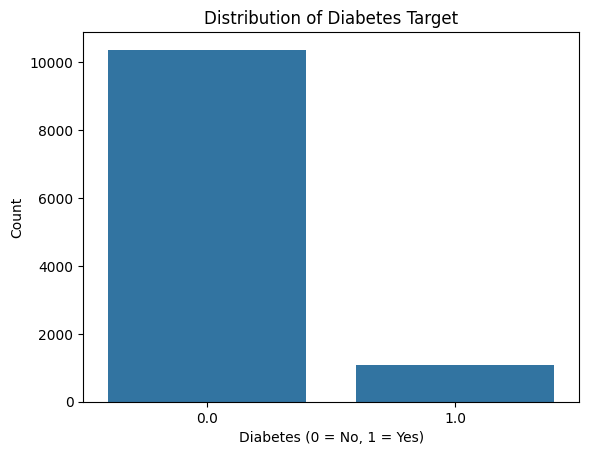

Class Distribution (%):
Diabetes
0.0    90.560601
1.0     9.439399
Name: proportion, dtype: float64


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.countplot(x=diabetes_df["Diabetes"])
plt.title("Distribution of Diabetes Target")
plt.xlabel("Diabetes (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

class_counts = diabetes_df["Diabetes"].value_counts(normalize=True) * 100
print("Class Distribution (%):")
print(class_counts)


So clearly there is class imbalance which will become one of reason why we will use class weights and threshold tuning.

# Correlation Screening (Domain by Domain)

We compute the correlation between each variable and the diabetes target
to identify potential correlated features that we can use in modelling.

In [9]:
pd.read_csv("data/csv_named/diabetes.csv").columns

Index(['SEQN', 'EverTold_Diabetes', 'Age_DiabetesDiagnosis',
       'EverTold_Prediabetes', 'BloodSugarTest_Last3Years',
       'CurrentlyTaking_Insulin', 'InsulinDuration', 'Unnamed: 7',
       'CurrentlyTaking_DiabeticPills'],
      dtype='object')

In [10]:
import os
import numpy as np
import pandas as pd

all_correlations = []

for file in os.listdir("data/csv_named"):
    
    if file.endswith(".csv") and file != "diabetes.csv":
        
        df = pd.read_csv(f"data/csv_named/{file}")
        
        if "SEQN" not in df.columns:
            continue
        
        merged = df.merge(
            diabetes_df[["SEQN", "Diabetes"]],
            on="SEQN",
            how="left"
        )
        
        for col in merged.columns:
            
            if col not in ["SEQN", "Diabetes"]:
                
                if pd.api.types.is_numeric_dtype(merged[col]):
                    
                    if merged[col].nunique(dropna=True) <= 1:
                        continue
                    
                    corr = merged[col].corr(merged["Diabetes"])
                    
                    if pd.isna(corr):
                        continue
                    
                    all_correlations.append({
                        "File": file,
                        "Variable": col,
                        "Correlation": corr,
                        "Abs_Correlation": abs(corr)
                    })

corr_df = pd.DataFrame(all_correlations)

corr_df = corr_df.sort_values("Abs_Correlation", ascending=False)

os.makedirs("outputs", exist_ok=True)
corr_df.to_csv("outputs/ALL_VARIABLE_CORRELATIONS.csv", index=False)

corr_df.head(20)

/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: inv

,File,Variable,Correlation,Abs_Correlation
165,prescription_medications.csv,PrescriptionMeds_Count_Last30Days,0.386259,0.386259
28,hospital_utilization_access_to_care.csv,GeneralHealth_Status,0.308175,0.308175
52,functioning.csv,DifficultyWalkingClimbingSteps_Level,0.273509,0.273509
166,blood_pressure_cholesterol.csv,EverTold_Hypertension,-0.267956,0.267956
164,prescription_medications.csv,PrescriptionMedication_Used_Last30Days,-0.258018,0.258018
101,smoking_recent_tobacco_use.csv,ProductsUsed_4,-0.249237,0.249237
170,blood_pressure_cholesterol.csv,CurrentlyTaking_CholesterolMedication,-0.224634,0.224634
95,smoking_recent_tobacco_use.csv,NumberOfDaysSmokedPipe_5Days,-0.222394,0.222394
83,oral_health.csv,OverallHealth_TeethAndGums,0.213378,0.213378
180,preventive_aspirin_use.csv,EverTold_TakeAspirin,-0.194951,0.194951


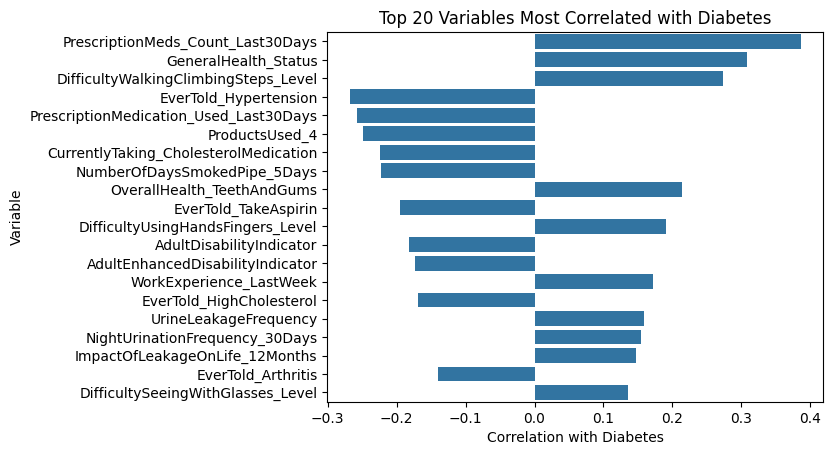

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

top_corr = corr_df.head(20)

plt.figure()
sns.barplot(
    x="Correlation",
    y="Variable",
    data=top_corr
)
plt.title("Top 20 Variables Most Correlated with Diabetes")
plt.xlabel("Correlation with Diabetes")
plt.ylabel("Variable")
plt.show()


# Creating a Merged Dataset

After completing some basic work i thought thst merging all CSV to get a merged Master CSV might help in work ahead.

Until now, all NHANES domains were analyzed separately.
However, for proper missingness analysis, feature filtering,
and baseline modeling, all variables existing in one table can help.

Merge strategy:
- Start with the cleaned diabetes dataset (contains the target variable).
- Left-join all other domain datasets on `SEQN`.
- Preserve all diabetes records.


This produces the full master dataset before any feature filtering,
missingness removal, or leakage elimination.

In [12]:
import os
import pandas as pd

master = diabetes_df.copy()

for file in os.listdir("data/csv_named"):
    
    if file.endswith(".csv") and file != "diabetes.csv":
        
        df = pd.read_csv(f"data/csv_named/{file}")
        
        if "SEQN" in df.columns:
            master = master.merge(df, on="SEQN", how="left")

print("Master shape:", master.shape)

os.makedirs("outputs", exist_ok=True)
master.to_csv("outputs/master_full.csv", index=False)

master.head()

Master shape: (11744, 253)


,SEQN,EverTold_Diabetes,Age_DiabetesDiagnosis,EverTold_Prediabetes,BloodSugarTest_Last3Years,CurrentlyTaking_Insulin,InsulinDuration,Unnamed: 7,CurrentlyTaking_DiabeticPills,Diabetes,...,HealthInsurance_OtherGovernmentInsurance,NoHealthInsurance_Past12Months,SmokedAtLeast100CigarettesInLife,CurrentCigaretteSmoking,CigarettesSmokedDays_30Days,CigarettesPerDayOnSmokingDays_30Days,SmokingTypeMenthol,TotalCigarettesSmoked,FirstCigaretteAge,QuestionnaireModeFlag
0,130378.0,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,0.0,...,NaN,2.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0
1,130379.0,2.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,0.0,...,NaN,2.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0
2,130380.0,1.0,35.0,NaN,NaN,2.0,NaN,NaN,1.0,1.0,...,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,130381.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Missingness Analysis on Master Dataset

After merging all files into a single master dataset,lets evaluate the percentage of missing values for each variable.

This step helps us:
- Identify variables with extremely high missingness (>95%)
- Decide which variables to drop before modeling
- Plan appropriate strategies

We compute the proportion of missing values for every column
in the merged dataset.

In [13]:
missing_pct = master.isnull().mean().sort_values(ascending=False)

missing_df = missing_pct.reset_index()
missing_df.columns = ["Variable", "Missing_Percentage"]

missing_df.to_csv("outputs/master_missingness.csv", index=False)

print("Top 20 Most Missing Variables:")
missing_df.head(20)

Top 20 Most Missing Variables:


,Variable,Missing_Percentage
0,MoreThan3Cancers,0.999830
1,TypeOfLiverCondition_2,0.999659
2,ProductsUsed_5,0.999319
3,TypeOfLiverCondition_5,0.998638
4,FirstTypeOfMilkFed_4,0.998638
5,FirstTypeOfMilkFed_5,0.998212
6,DifficultyWalkingWithoutAssistance_Level,0.998127
7,FirstCigaretteAge,0.998042
8,ProductsUsed_2,0.997871
9,NumberOfDaysSmokedPipe_5Days,0.997871


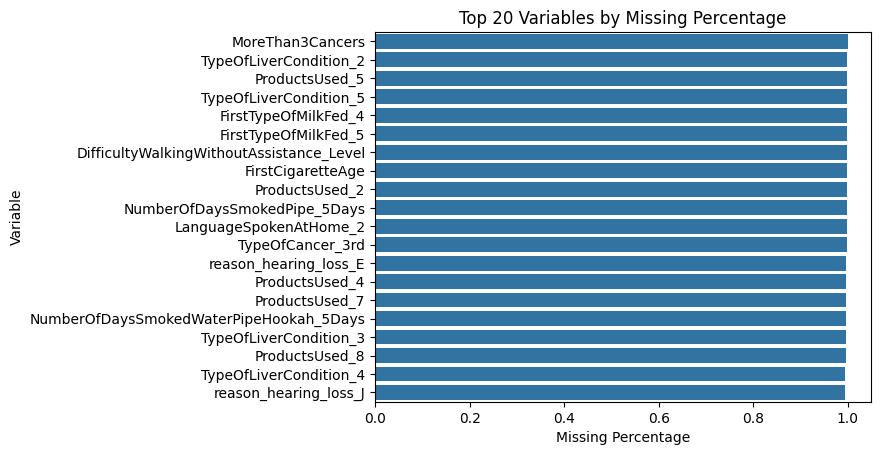

In [14]:
top_missing = missing_df.head(20)

plt.figure()
sns.barplot(
    x="Missing_Percentage",
    y="Variable",
    data=top_missing
)
plt.title("Top 20 Variables by Missing Percentage")
plt.xlabel("Missing Percentage")
plt.ylabel("Variable")
plt.show()


# Removing Highly Missing Variables

To avoid noise and unreliable imputations, we remove all variables with
more than 95% missing values.

This step simplifies the dataset while preserving all meaningful information.

In [15]:
threshold = 0.95

missing_summary = pd.read_csv("outputs/master_missingness.csv")

cols_to_drop = missing_summary[
    missing_summary["Missing_Percentage"] > threshold
]["Variable"].tolist()

print(f"Dropping {len(cols_to_drop)} columns with >95% missingness")

master_reduced = master.drop(columns=cols_to_drop)

print("Shape before:", master.shape)
print("Shape after:", master_reduced.shape)

# Save intermediate dataset
master_reduced.to_csv("outputs/master_after_missing_drop.csv", index=False)

master_reduced.head()

Dropping 48 columns with >95% missingness
Shape before: (11744, 253)
Shape after: (11744, 205)


,SEQN,EverTold_Diabetes,Age_DiabetesDiagnosis,EverTold_Prediabetes,BloodSugarTest_Last3Years,CurrentlyTaking_Insulin,CurrentlyTaking_DiabeticPills,Diabetes,NumberOfPeopleSmokingInHome,NumberOfPeopleSmokingInsideHome,...,HealthInsurance_Medicare,HealthInsurance_Medicaid,HealthInsurance_StateSponsoredHealthPlan,NoHealthInsurance_Past12Months,SmokedAtLeast100CigarettesInLife,CurrentCigaretteSmoking,CigarettesPerDayOnSmokingDays_30Days,SmokingTypeMenthol,TotalCigarettesSmoked,QuestionnaireModeFlag
0,130378.0,2.0,NaN,2.0,2.0,NaN,NaN,0.0,5.397605e-79,NaN,...,NaN,NaN,NaN,2.0,1.0,3.0,NaN,NaN,NaN,1.0
1,130379.0,2.0,NaN,2.0,1.0,NaN,NaN,0.0,5.397605e-79,NaN,...,2.0,NaN,NaN,2.0,1.0,3.0,NaN,NaN,NaN,1.0
2,130380.0,1.0,35.0,NaN,NaN,2.0,1.0,1.0,5.397605e-79,NaN,...,NaN,NaN,8.0,1.0,2.0,NaN,NaN,NaN,NaN,1.0
3,130381.0,2.0,NaN,NaN,NaN,NaN,NaN,0.0,5.397605e-79,NaN,...,NaN,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,2.0,NaN,NaN,NaN,NaN,NaN,0.0,5.397605e-79,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


# Removing Leakage Variables

Certain variables directly reveal diabetes diagnosis or treatment status.
Including these would artificially inflate model performance.

We remove:
- Age at diabetes diagnosis
- Insulin usage
- Diabetes medication indicators

These variables will not be used for modeling.

In [16]:
leakage_report = []

for col in master_reduced.columns:
    
    if col in ["SEQN", "Diabetes"]:
        continue
    
    series = master_reduced[col]
    
    # Skip if completely empty
    if series.notnull().sum() == 0:
        continue
    
    entry = {"Variable": col}
    
    # Correlation (if numeric)
    if pd.api.types.is_numeric_dtype(series):
        corr = series.corr(master_reduced["Diabetes"])
        entry["Correlation"] = corr
    else:
        entry["Correlation"] = None
    
    # Binary conditional probability check
    if series.dropna().nunique() == 2:
        if 1 in series.unique():
            subset = master_reduced[series == 1]
            if len(subset) > 0:
                entry["P(D=1 | var=1)"] = subset["Diabetes"].mean()
            else:
                entry["P(D=1 | var=1)"] = None
        else:
            entry["P(D=1 | var=1)"] = None
    else:
        entry["P(D=1 | var=1)"] = None
    
    # Check if non-null only in diabetics
    non_null_subset = master_reduced[series.notnull()]
    if len(non_null_subset) > 0:
        entry["AllNonNullAreDiabetic"] = (
            non_null_subset["Diabetes"].mean() == 1.0
        )
    else:
        entry["AllNonNullAreDiabetic"] = None
    
    leakage_report.append(entry)

leakage_df = pd.DataFrame(leakage_report)

# Sort by absolute correlation
leakage_df["Abs_Corr"] = leakage_df["Correlation"].abs()
leakage_df = leakage_df.sort_values("Abs_Corr", ascending=False)

leakage_df.head(20)

/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,Variable,Correlation,P(D=1 | var=1),AllNonNullAreDiabetic,Abs_Corr
0,EverTold_Diabetes,-1.000000,NaN,False,1.000000
5,CurrentlyTaking_DiabeticPills,-0.505087,NaN,False,0.505087
172,PrescriptionMeds_Count_Last30Days,0.386259,NaN,False,0.386259
39,GeneralHealth_Status,0.308175,NaN,False,0.308175
63,DifficultyWalkingClimbingSteps_Level,0.273509,NaN,False,0.273509
173,EverTold_Hypertension,-0.267956,NaN,False,0.267956
171,PrescriptionMedication_Used_Last30Days,-0.258018,NaN,False,0.258018
177,CurrentlyTaking_CholesterolMedication,-0.224634,NaN,False,0.224634
103,OverallHealth_TeethAndGums,0.213378,NaN,False,0.213378
188,EverTold_TakeAspirin,-0.194951,NaN,False,0.194951


In [17]:
# Confirmed leakage variables
confirmed_leakage = [
    "EverTold_Diabetes",
    "CurrentlyTaking_DiabeticPills",
    "CurrentlyTaking_Insulin",
    "InsulinDuration",
    "Age_DiabetesDiagnosis"
]

confirmed_leakage = [col for col in confirmed_leakage if col in master_reduced.columns]

print("Removing confirmed leakage variables:", confirmed_leakage)

master_clean = master_reduced.drop(columns=confirmed_leakage)

print("Final shape after leakage removal:", master_clean.shape)

master_clean.to_csv("outputs/master_clean.csv", index=False)

Removing confirmed leakage variables: ['EverTold_Diabetes', 'CurrentlyTaking_DiabeticPills', 'CurrentlyTaking_Insulin', 'Age_DiabetesDiagnosis']
Final shape after leakage removal: (11744, 201)


# Post Cleaning Data Check

After removing high-missing and leakage variables,
we inspect the remaining dataset to understand:

- Overall missingness structure
- Distribution of missing values
- Numeric vs categorical feature counts

This prepares us for a structured imputation strategy.

In [18]:
overall_missing = master_clean.isnull().mean().mean()
print("Overall average missing percentage:", round(overall_missing * 100, 2), "%")

moderate_missing = master_clean.isnull().mean()
moderate_missing = moderate_missing[moderate_missing > 0.20].sort_values(ascending=False)

print("\nColumns with >20% missing:")
print(moderate_missing.head(20))

numeric_cols = master_clean.select_dtypes(include=["number"]).columns
categorical_cols = master_clean.select_dtypes(exclude=["number"]).columns

print("\nNumeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))

Overall average missing percentage: 51.78 %

Columns with >20% missing:
LanguageSpokenAtHome_3                      0.941332
TotalCigarettesSmoked                       0.934264
LastCigaretteSmoked                         0.933243
DaysSmokedCigarettes_5Days                  0.932902
CigarettesSmokedPerSmokingDay_5Days         0.932902
ProductsUsed_1                              0.932561
reason_hearing_loss_H                       0.931369
FirstTypeOfMilkFed_1                        0.926686
AgeStoppedBreastfeeding                     0.918512
AgeStoppedDrinkingFormula                   0.914595
StillHave_ThyroidProblem                    0.910337
HealthInsurance_StateSponsoredHealthPlan    0.906846
TypeOfCancer_1st                            0.900460
SmokingTypeMenthol                          0.899949
reason_hearing_loss_I                       0.899608
CigarettesPerDayOnSmokingDays_30Days        0.899097
AsthmaEpisode_Last12Months                  0.896202
EmergencyVisit_Asthma_Last1

In [19]:
import pandas as pd

missing_df = pd.read_csv("outputs/master_missingness.csv")

# Create missingness bands
def categorize_missing(p):
    if p > 0.95:
        return ">95% (Drop)"
    elif p > 0.50:
        return "50–95% (Careful)"
    elif p > 0.20:
        return "20–50% (Impute Carefully)"
    elif p > 0:
        return "0–20% (Safe to Impute)"
    else:
        return "No Missing"

missing_df["Missing_Category"] = missing_df["Missing_Percentage"].apply(categorize_missing)

missing_summary = missing_df["Missing_Category"].value_counts()

missing_summary

Missing_Category
50–95% (Careful)             112
20–50% (Impute Carefully)     70
>95% (Drop)                   48
0–20% (Safe to Impute)        19
No Missing                     4
Name: count, dtype: int64

In [20]:
missing_corr = []

for col in master_clean.columns:
    if col != "Diabetes":
        missing_indicator = master_clean[col].isna().astype(int)
        corr = missing_indicator.corr(master_clean["Diabetes"])
        missing_corr.append((col, corr))

missing_corr_df = pd.DataFrame(missing_corr, columns=["Variable", "Missing_Corr_with_Diabetes"])
missing_corr_df = missing_corr_df.sort_values("Missing_Corr_with_Diabetes", ascending=False)

missing_corr_df.head(20)

/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: inv

,Variable,Missing_Corr_with_Diabetes
2,BloodSugarTest_Last3Years,0.493636
1,EverTold_Prediabetes,0.493533
81,CurrentlyAttendingSchool,0.199935
130,BirthWeight_1,0.198329
131,BirthWeight_2,0.198329
133,OverweightDiagnosis,0.190465
132,WeightAssessment,0.190465
28,ScreenTime_TypicalDay_SchoolYear,0.189587
27,Days_PhysicallyActive_AtLeast60Min_Last7Days,0.189587
54,DifficultyMakingFriends_Level,0.176914


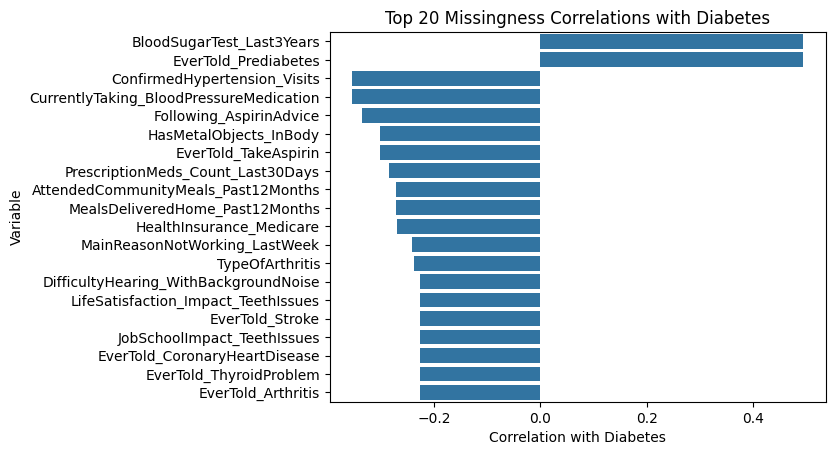

In [21]:
top_corr = missing_corr_df.reindex(
    missing_corr_df["Missing_Corr_with_Diabetes"].abs().sort_values(ascending=False).index
).head(20)

plt.figure()
sns.barplot(
    x="Missing_Corr_with_Diabetes",
    y="Variable",
    data=top_corr
)
plt.title("Top 20 Missingness Correlations with Diabetes")
plt.xlabel("Correlation with Diabetes")
plt.ylabel("Variable")
plt.show()


In [22]:
import numpy as np

missing_corr_list = []

for col in master_clean.columns:
    
    if col in ["SEQN", "Diabetes"]:
        continue
    
    # Create missing indicator (1 if missing, 0 if present)
    missing_indicator = master_clean[col].isna().astype(int)
    
    # Only compute if there is variation
    if missing_indicator.nunique() > 1:
        
        corr = missing_indicator.corr(master_clean["Diabetes"])
        
        missing_corr_list.append({
            "Variable": col,
            "Missing_Percentage": master_clean[col].isna().mean(),
            "Missing_Corr_with_Diabetes": corr
        })

missing_analysis = pd.DataFrame(missing_corr_list)

missing_analysis = missing_analysis.sort_values(
    "Missing_Corr_with_Diabetes", 
    ascending=False
)

missing_analysis.head(20)

/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: inv

,Variable,Missing_Percentage,Missing_Corr_with_Diabetes
1,BloodSugarTest_Last3Years,0.292916,0.493636
0,EverTold_Prediabetes,0.316928,0.493533
77,CurrentlyAttendingSchool,0.714152,0.199935
126,BirthWeight_1,0.723859,0.198329
127,BirthWeight_2,0.723859,0.198329
129,OverweightDiagnosis,0.739101,0.190465
128,WeightAssessment,0.739101,0.190465
27,ScreenTime_TypicalDay_SchoolYear,0.741059,0.189587
26,Days_PhysicallyActive_AtLeast60Min_Last7Days,0.741059,0.189587
50,DifficultyMakingFriends_Level,0.762687,0.176914


In [23]:
# Filter 50–95% group
mid_high_missing = missing_analysis[
    (missing_analysis["Missing_Percentage"] > 0.5) &
    (missing_analysis["Missing_Percentage"] <= 0.95)
]

# Sort by absolute correlation
mid_high_missing = mid_high_missing.sort_values(
    by="Missing_Corr_with_Diabetes",
    key=abs,
    ascending=False
)

mid_high_missing.head(20)

,Variable,Missing_Percentage,Missing_Corr_with_Diabetes
167,ConfirmedHypertension_Visits,0.747275,-0.353276
168,CurrentlyTaking_BloodPressureMedication,0.747190,-0.353168
182,Following_AspirinAdvice,0.825528,-0.335533
163,HasMetalObjects_InBody,0.512687,-0.301700
181,EverTold_TakeAspirin,0.513624,-0.300552
76,AttendedCommunityMeals_Past12Months,0.701975,-0.271742
75,MealsDeliveredHome_Past12Months,0.701975,-0.271742
186,HealthInsurance_Medicare,0.763624,-0.269314
25,MainReasonNotWorking_LastWeek,0.692268,-0.240913
148,TypeOfArthritis,0.784401,-0.237238


In [24]:
mid_group = missing_analysis[
    (missing_analysis["Missing_Percentage"] > 0.5) &
    (missing_analysis["Missing_Percentage"] <= 0.95)
]

strong = mid_group[abs(mid_group["Missing_Corr_with_Diabetes"]) > 0.15]
medium = mid_group[
    (abs(mid_group["Missing_Corr_with_Diabetes"]) > 0.05) &
    (abs(mid_group["Missing_Corr_with_Diabetes"]) <= 0.15)
]
weak = mid_group[abs(mid_group["Missing_Corr_with_Diabetes"]) <= 0.05]

print("Strong:", len(strong))
print("Medium:", len(medium))
print("Weak:", len(weak))

Strong: 41
Medium: 50
Weak: 18


# Removing High Missing Low Signal Variables

After analyzing missingness patterns, we categorized variables in the 50–95% 
missing group into:

- Strong signal
- Medium signal
- Weak signal

Variables in the weak category have:
- High missingness (50–95%)
- Very low correlation with diabetes (|corr| ≤ 0.05)

These variables contribute little predictive value while increasing
model instability due to heavy imputation.

Therefore, we remove them before proceeding further.

In [25]:
# Identify weak variables in 50–95% missing range

mid_group = missing_analysis[
    (missing_analysis["Missing_Percentage"] > 0.5) &
    (missing_analysis["Missing_Percentage"] <= 0.95)
]

weak_group = mid_group[
    abs(mid_group["Missing_Corr_with_Diabetes"]) <= 0.05
]

cols_to_drop_weak = weak_group["Variable"].tolist()

print(f"Dropping {len(cols_to_drop_weak)} weak high-missing variables")

master_step1 = master_clean.drop(columns=cols_to_drop_weak)

print("Shape before:", master_clean.shape)
print("Shape after:", master_step1.shape)

# Save intermediate version
master_step1.to_csv("outputs/master_after_weak_drop.csv", index=False)

Dropping 18 weak high-missing variables
Shape before: (11744, 201)
Shape after: (11744, 183)


# Investigating Structural Missingness

Before applying any imputation strategy, we must determine
whether missingness is:

1. Structural (due to NHANES skip patterns)
2. Subgroup-based (age or condition specific)
3. Random missingness

Structural missingness should not be imputed blindly.
It often represents meaningful information about eligibility
or questionnaire branching logic.

In [26]:
# Recalculate missing correlation on current dataset

missing_stats = []

for col in master_step1.columns:
    
    if col not in ["SEQN", "Diabetes"]:
        
        missing_flag = master_step1[col].isna().astype(int)
        
        corr = missing_flag.corr(master_step1["Diabetes"])
        
        missing_stats.append({
            "Variable": col,
            "Missing_Percentage": master_step1[col].isna().mean(),
            "Missing_Corr_with_Diabetes": corr
        })

missing_analysis_step2 = pd.DataFrame(missing_stats)

missing_analysis_step2 = missing_analysis_step2.sort_values(
    by="Missing_Corr_with_Diabetes",
    key=abs,
    ascending=False
)

missing_analysis_step2.head(20)

/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mankirat/25ws-42.17/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: inv

,Variable,Missing_Percentage,Missing_Corr_with_Diabetes
1,BloodSugarTest_Last3Years,0.292916,0.493636
0,EverTold_Prediabetes,0.316928,0.493533
154,ConfirmedHypertension_Visits,0.747275,-0.353276
155,CurrentlyTaking_BloodPressureMedication,0.747190,-0.353168
169,Following_AspirinAdvice,0.825528,-0.335533
150,HasMetalObjects_InBody,0.512687,-0.301700
168,EverTold_TakeAspirin,0.513624,-0.300552
152,PrescriptionMeds_Count_Last30Days,0.470027,-0.283505
72,AttendedCommunityMeals_Past12Months,0.701975,-0.271742
71,MealsDeliveredHome_Past12Months,0.701975,-0.271742


# Removing Child-Specific Survey Modules

Several variables belong to NHANES child-only modules 
(e.g., birth weight, school activity, breastfeeding history).

These variables:
- Are structurally missing for most adults
- Do not contribute meaningful signal to adult diabetes prediction
- Inflate dimensionality and missingness

To maintain model stability and interpretability,
we remove child-only modules before imputation.

In [27]:
child_variables = [
    "BirthWeight_1", "BirthWeight_2",
    "WeightAssessment", "OverweightDiagnosis",
    "CurrentlyAttendingSchool",
    "ScreenTime_TypicalDay_SchoolYear",
    "Days_PhysicallyActive_AtLeast60Min_Last7Days",
    "ChildDisabilityIndicator",
    "AgeStoppedBreastfeeding",
    "AgeFirstFedMilk",
    "AgeFirstFedOtherThanBreastMilk_inDays",
    "AgeStoppedDrinkingFormula"
]

# Add FirstTypeOfMilkFed variables dynamically
child_variables += [col for col in master_step1.columns if "FirstTypeOfMilkFed" in col]

# Drop if they exist
child_variables = [col for col in child_variables if col in master_step1.columns]

master_step2 = master_step1.drop(columns=child_variables)

print("Shape before:", master_step1.shape)
print("Shape after:", master_step2.shape)

master_step2.to_csv("outputs/master_after_child_drop.csv", index=False)

Shape before: (11744, 183)
Shape after: (11744, 170)


# Handling Structural Condition Based Missingness

Several variables are condition specific follow up questions
(hypertension medication, arthritis subtype).

Missing values occur because the participant
does not have the condition.

These are not random missing values.

Therefore:
- Missing values are replaced with an explicit category
  representing "NotApplicable".

In [28]:
condition_followups = [
    "ConfirmedHypertension_Visits",
    "CurrentlyTaking_BloodPressureMedication",
    "Following_AspirinAdvice",
    "TypeOfArthritis"
]

for col in condition_followups:
    if col in master_step2.columns:
        master_step2[col] = master_step2[col].fillna(-1)  # -1 = NotApplicable

master_step2.to_csv("outputs/master_after_structural_handling.csv", index=False)

In [29]:
# Recalculate missingness on master_step2
missing_step2 = pd.DataFrame({
    "Variable": master_step2.columns,
    "Missing_Percentage": master_step2.isna().mean()
}).sort_values("Missing_Percentage", ascending=False)

missing_step2.to_csv("outputs/master_missingness_step2.csv", index=False)

missing_step2.head(20)

,Variable,Missing_Percentage
TotalCigarettesSmoked,TotalCigarettesSmoked,0.934264
LastCigaretteSmoked,LastCigaretteSmoked,0.933243
DaysSmokedCigarettes_5Days,DaysSmokedCigarettes_5Days,0.932902
CigarettesSmokedPerSmokingDay_5Days,CigarettesSmokedPerSmokingDay_5Days,0.932902
ProductsUsed_1,ProductsUsed_1,0.932561
reason_hearing_loss_H,reason_hearing_loss_H,0.931369
StillHave_ThyroidProblem,StillHave_ThyroidProblem,0.910337
TypeOfCancer_1st,TypeOfCancer_1st,0.900460
SmokingTypeMenthol,SmokingTypeMenthol,0.899949
reason_hearing_loss_I,reason_hearing_loss_I,0.899608


In [30]:
high_sparse = missing_step2[
    missing_step2["Missing_Percentage"] > 0.85
]["Variable"].tolist()

print("Dropping:", len(high_sparse), "very sparse columns")

master_step3 = master_step2.drop(columns=high_sparse)

print("Shape before:", master_step2.shape)
print("Shape after:", master_step3.shape)

Dropping: 19 very sparse columns
Shape before: (11744, 170)
Shape after: (11744, 151)


In [31]:
missing_step3 = master_step3.isnull().mean().sort_values(ascending=False)

zone_50_80 = missing_step3[(missing_step3 >= 0.5) & (missing_step3 < 0.85)]
zone_20_50 = missing_step3[(missing_step3 >= 0.2) & (missing_step3 < 0.5)]
zone_0_20 = missing_step3[(missing_step3 > 0) & (missing_step3 < 0.2)]

print("50–80%:", len(zone_50_80))
print("20–50%:", len(zone_20_50))
print("0–20%:", len(zone_0_20))

50–80%: 55
20–50%: 70
0–20%: 18


In [32]:
zone_0_20_vars = zone_0_20.index.tolist()

num_cols = master_step3[zone_0_20_vars].select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_cols = master_step3[zone_0_20_vars].select_dtypes(include=["object"]).columns.tolist()

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

Numeric: ['FamilyPovertyLevelIndex_Categories', 'MoreThan5000_InSavings', 'NumberOfRooms_Home', 'NumberOfPeopleSmokingInHome', 'UsualPlace_Type', 'EverTold_HepatitisB', 'NoHealthInsurance_Past12Months', 'MentalHealthVisit_Past12Months', 'Diabetes', 'EverReceived_HepatitisAVaccine', 'PrescriptionMedication_Used_Last30Days', 'Has_HealthInsurance', 'OverallHealth_TeethAndGums', 'MouthPain_Frequency_LastYear', 'HearingStatus_NoAid', 'AnemiaTreatment_Last3Months', 'EverTold_Asthma', 'HayFeverEpisode_Past12Month']
Categorical: []


In [33]:
master_step3 = master_step3.drop(columns=["SEQN"])
master_step3 = master_step3.dropna(subset=["Diabetes"]).copy()

In [34]:
# Drop problematic byte/time columns
cols_to_drop_time = [
    "WeekdaySleepTime",
    "WeekdayWakeTime",
    "WeekendSleepTime",
    "WeekendWakeTime"
]

for col in cols_to_drop_time:
    if col in master_step3.columns:
        master_step3 = master_step3.drop(columns=[col])

print("Shape after dropping time columns:", master_step3.shape)

Shape after dropping time columns: (11452, 146)


# Baseline Modeling Setup

After completing missingness handling and leakage removal,
we now construct the modeling dataset.

Goal:
- Predict Diabetes (binary classification)
- Primary evaluation metric: Recall
- Secondary metrics: Precision, ROC AUC


In [35]:
forbidden = [
    "EverTold_Prediabetes",
    "BloodSugarTest_Last3Years"
]

X_full = master_step3.drop(columns=["Diabetes"]).copy()

X_full = X_full.drop(columns=[c for c in forbidden if c in X_full.columns])

y_full = master_step3["Diabetes"].copy()

print("Initial feature count:", X_full.shape[1])

Initial feature count: 143


In [36]:
from sklearn.model_selection import train_test_split

X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

print("Train shape:", X_train_full.shape)
print("Test shape:", X_test_full.shape)

Train shape: (9161, 143)
Test shape: (2291, 143)


In [37]:
from sklearn.impute import SimpleImputer
import pandas as pd

X_rank = X_train_full.copy()

# Separate numeric & categorical
num_cols = X_rank.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_rank.select_dtypes(include=["object"]).columns

# Impute numeric
num_imputer = SimpleImputer(strategy="median")
X_rank[num_cols] = num_imputer.fit_transform(X_rank[num_cols])

# Impute categorical
for c in cat_cols:
    X_rank[c] = X_rank[c].astype(str).fillna("MISSING")

# Encode categorical quickly
for c in cat_cols:
    X_rank[c] = pd.factorize(X_rank[c])[0]

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf_rank = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_rank.fit(X_rank, y_train)

importances = pd.Series(
    rf_rank.feature_importances_,
    index=X_rank.columns
).sort_values(ascending=False)

topN = 45  #features we want
top_features = importances.head(topN).index.tolist()

print("Top 45 features:")
print(importances.head(topN))

Top 45 features:
PrescriptionMeds_Count_Last30Days          0.096631
CurrentlyTaking_CholesterolMedication      0.062942
PrescriptionMedication_Used_Last30Days     0.050648
EverTold_Hypertension                      0.040025
CurrentlyTaking_BloodPressureMedication    0.037188
ConfirmedHypertension_Visits               0.036903
GeneralHealth_Status                       0.032925
WeightOneYearAgo                           0.028876
CurrentWeight                              0.026705
EverTold_HighCholesterol                   0.026227
DifficultyWalkingClimbingSteps_Level       0.023641
Following_AspirinAdvice                    0.022283
EverTold_TakeAspirin                       0.018946
FamilyPovertyLevelIndex_Ratio              0.015160
SittingTime_TypicalDay                     0.014195
Frequency_VigorousActivity.1               0.013937
Frequency_ModerateActivity.1               0.013788
OverallHealth_TeethAndGums                 0.013076
CurrentHeight                              0.01

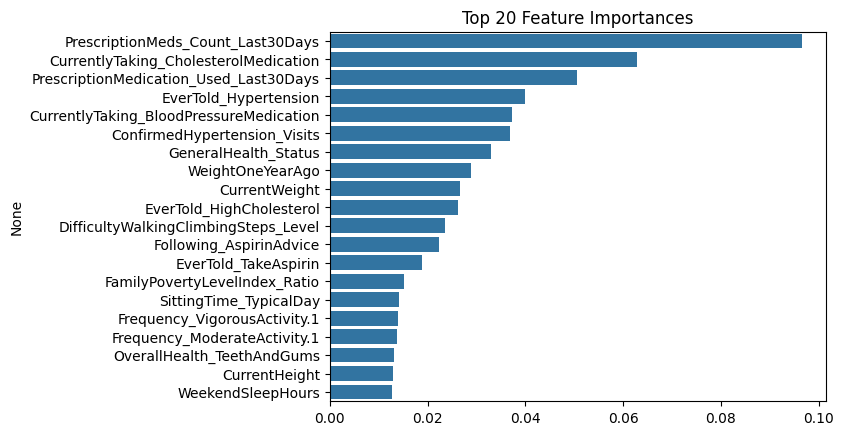

In [39]:
top_importances = importances.head(20)

plt.figure()
sns.barplot(
    x=top_importances.values,
    y=top_importances.index
)
plt.title("Top 20 Feature Importances")
plt.show()


In [40]:
X_train = X_train_full[top_features].copy()
X_test = X_test_full[top_features].copy()

print("Final feature count:", len(top_features))

Final feature count: 45


In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Detect types again (important after feature selection)
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, cat_cols)
])

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

models = {
    "Logistic": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(
        n_estimators=400,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        random_state=42
    )
}

In [45]:
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score
)

results = []
fitted_pipelines = {}  

for name, clf in models.items():
    
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("clf", clf)
    ])
    
    pipe.fit(X_train, y_train)
    probs = pipe.predict_proba(X_test)[:, 1]
    
    fitted_pipelines[name] = pipe   
    
    thresholds = np.linspace(0.05, 0.8, 50)
    best_f1 = 0
    best_threshold = 0
    
    for t in thresholds:
        preds = (probs >= t).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
    
    final_preds = (probs >= best_threshold).astype(int)
    
    results.append({
        "Model": name,
        "ROC-AUC": roc_auc_score(y_test, probs),
        "Best Threshold": best_threshold,
        "Recall": recall_score(y_test, final_preds),
        "Precision": precision_score(y_test, final_preds),
        "F1": best_f1
    })

results_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)
results_df


,Model,ROC-AUC,Best Threshold,Recall,Precision,F1
2,Gradient Boosting,0.916714,0.310204,0.606481,0.490637,0.542443
0,Logistic,0.910877,0.784694,0.652778,0.439252,0.525140
1,Random Forest,0.905664,0.279592,0.587963,0.463504,0.518367


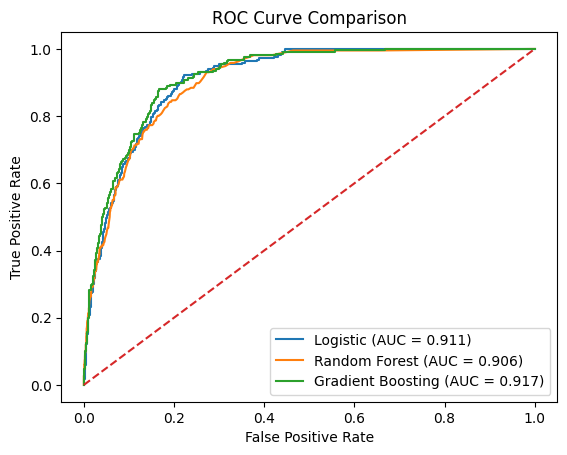

In [46]:
from sklearn.metrics import roc_curve, auc

plt.figure()

for name, pipe in fitted_pipelines.items():
    probs = pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


# Model Selection

So, I selected gradient boosting as my best model because it gave me the best ROC and F1 Score Values(Overall Best Model).
Now we will try to find optimal threshold for our given problem.

In [47]:
from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np
import pandas as pd

# Use already trained final_pipe
probs = pipe.predict_proba(X_test)[:, 1]

# Define threshold range
thresholds = np.arange(0.06, 0.31, 0.02)

results = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    
    results.append([t, recall, precision, f1])

threshold_df = pd.DataFrame(
    results,
    columns=["Threshold", "Recall", "Precision", "F1"]
)

print(threshold_df)


    Threshold    Recall  Precision        F1
0        0.06  0.907407   0.296073  0.446469
1        0.08  0.888889   0.325424  0.476427
2        0.10  0.879630   0.353160  0.503979
3        0.12  0.828704   0.366053  0.507801
4        0.14  0.782407   0.370614  0.502976
5        0.16  0.759259   0.384977  0.510903
6        0.18  0.745370   0.399504  0.520194
7        0.20  0.726852   0.415344  0.528620
8        0.22  0.689815   0.420904  0.522807
9        0.24  0.671296   0.438066  0.530165
10       0.26  0.657407   0.458065  0.539924
11       0.28  0.625000   0.467128  0.534653
12       0.30  0.611111   0.478261  0.536585


In [48]:
from sklearn.metrics import (
    recall_score,
    f1_score,
    accuracy_score,
    classification_report
)

threshold = 0.10   # change this to any threshold you want

probs = pipe.predict_proba(X_test)[:, 1]
preds = (probs >= threshold).astype(int)

recall_pos = recall_score(y_test, preds, pos_label=1)
f1_pos = f1_score(y_test, preds, pos_label=1)
accuracy = accuracy_score(y_test, preds)

print(f"Recall (Class 1): {recall_pos:.3f}")
print(f"F1 (Class 1): {f1_pos:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print()

print(classification_report(
    y_test,
    preds,
    target_names=["No Diabetes (0)", "Diabetes (1)"],
    digits=3
))


Recall (Class 1): 0.880
F1 (Class 1): 0.504
Accuracy: 0.837

                 precision    recall  f1-score   support

No Diabetes (0)      0.985     0.832     0.902      2075
   Diabetes (1)      0.353     0.880     0.504       216

       accuracy                          0.837      2291
      macro avg      0.669     0.856     0.703      2291
   weighted avg      0.926     0.837     0.865      2291



Threshold Used: 0.1
Recall (Diabetes): 0.880
F1 Score: 0.504
Accuracy: 0.837

                 precision    recall  f1-score   support

No Diabetes (0)      0.985     0.832     0.902      2075
   Diabetes (1)      0.353     0.880     0.504       216

       accuracy                          0.837      2291
      macro avg      0.669     0.856     0.703      2291
   weighted avg      0.926     0.837     0.865      2291



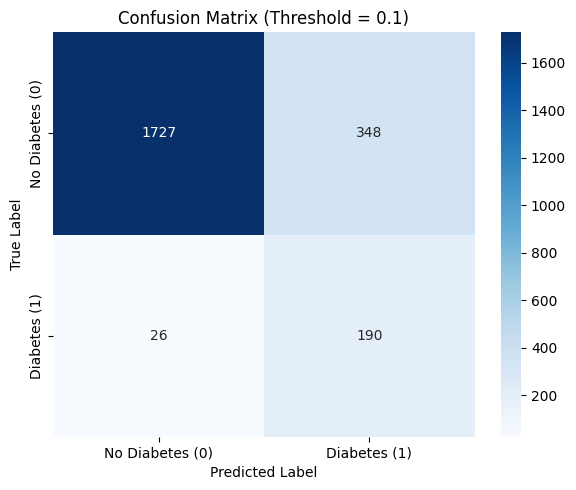

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    recall_score,
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix
)


pipe = fitted_pipelines["Gradient Boosting"]


threshold = 0.10   


probs = pipe.predict_proba(X_test)[:, 1]
preds = (probs >= threshold).astype(int)


recall_pos = recall_score(y_test, preds)
f1_pos = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)

print(f"Threshold Used: {threshold}")
print(f"Recall (Diabetes): {recall_pos:.3f}")
print(f"F1 Score: {f1_pos:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print()

print(classification_report(
    y_test,
    preds,
    target_names=["No Diabetes (0)", "Diabetes (1)"],
    digits=3
))


cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Diabetes (0)", "Diabetes (1)"],
            yticklabels=["No Diabetes (0)", "Diabetes (1)"])

plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


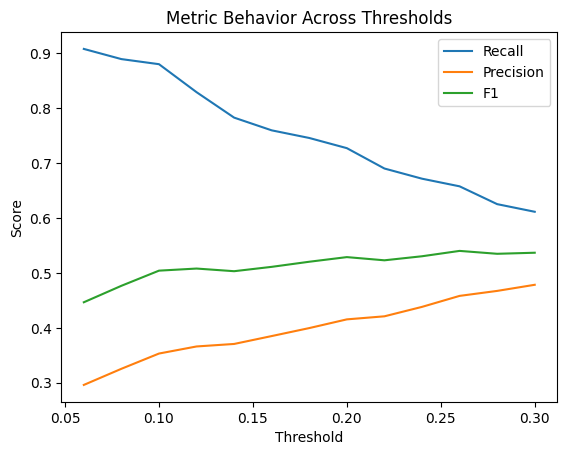

In [50]:
plt.figure()
plt.plot(threshold_df["Threshold"], threshold_df["Recall"], label="Recall")
plt.plot(threshold_df["Threshold"], threshold_df["Precision"], label="Precision")
plt.plot(threshold_df["Threshold"], threshold_df["F1"], label="F1")
plt.legend()
plt.title("Metric Behavior Across Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.show()
